# stock dataset

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval.random import RandomEvaluator
from opendataval.dataval.margcontrib import LeaveOneOut, DataShapley, BetaShapley
from opendataval.dataval.influence import InfluenceFunctionEval
from opendataval.dataval.dvrl import DVRL
from opendataval.dataval.knnshap import KNNShapley
from opendataval.dataval.margcontrib.banzhaf import DataBanzhaf
from opendataval.dataval.ame import AME
from opendataval.dataval.oob import DataOob

from opendataval.experiment import ExperimentMediator
from opendataval.model.mlp import RegressionMLP

## [Step 1] Set up an environment

### [Step 1-1] Define a DataFetcher from a registered dataset
`ExperimentMediator.model_factory_setup()` is convenient, but it only works for datasets registered in `opendataval`. To apply `opendataval` to your custome datasets, a user first needs to define a `DataFetcher` from a registered dataset. 

In [2]:
dataset_name = "stock"
train_count, valid_count, test_count = 100, 50, 50
noise_rate = 0.1
metric_name = "neg_mse"

fetcher = (
    DataFetcher(dataset_name, '../data_files/', False)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(add_gauss_noise, noise_rate=noise_rate)
)

/burg/stats/users/yk3012/software/miniconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### [Step 1-2] Set up a prediction model
Next is to set up a prediction model. The following code defines a multi-layer perceptron with two hidden layers. Each hidden layer has 25 nodes.

In [3]:
pred_model = RegressionMLP(fetcher.covar_dim[0], layers=2, hidden_dim=25)

### [Step 1-3] Combining all 
- Combining [Step 1-1] and [Step 1-2] with `ExperimentMediator`

In [4]:
exper_med = ExperimentMediator(fetcher, pred_model)

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [5]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
    BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000) # Data-OOB
]

In [6]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000822


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 99.90it/s]


Elapsed time LeaveOneOut(): 0:00:03.948550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.55it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:08.439802


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 103.40it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:19.392024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 13786.52it/s]

Elapsed time KNNShapley(k_neighbors=50): 0:00:00.058802
Start: marginal contribution computation



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]

gr_stat=1.0278463380032288
Done: marginal contribution computation


Elapsed time DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:02:46.819215
Elapsed time BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:00.000604


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.67it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:06.398847


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.99it/s]


Elapsed time AME(num_models=1000): 0:00:25.099027


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.91it/s]

Elapsed time DataOob(num_models=1000): 0:00:11.127224
CPU times: user 1min 19s, sys: 397 ms, total: 1min 19s
Wall time: 4min 1s


## [Step 3] Evaluate data values

In [7]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/stock_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: perturbed features with additive Gaussian noise

In [8]:
exper_med.evaluate(noisy_detection, save_output=True)

/burg/stats/users/yk3012/software/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


,kmeans_f1
AME(num_models=1000),0.181818
"BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.195122
DVRL(rl_epochs=2000),0.178571
DataBanzhaf(num_models=1000),0.206897
DataOob(num_models=1000),0.216216
"DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.162791
InfluenceFunctionEval(num_models=1000),0.202899
KNNShapley(k_neighbors=50),0.181818
LeaveOneOut(),0.181818
RandomEvaluator(),0.193548


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

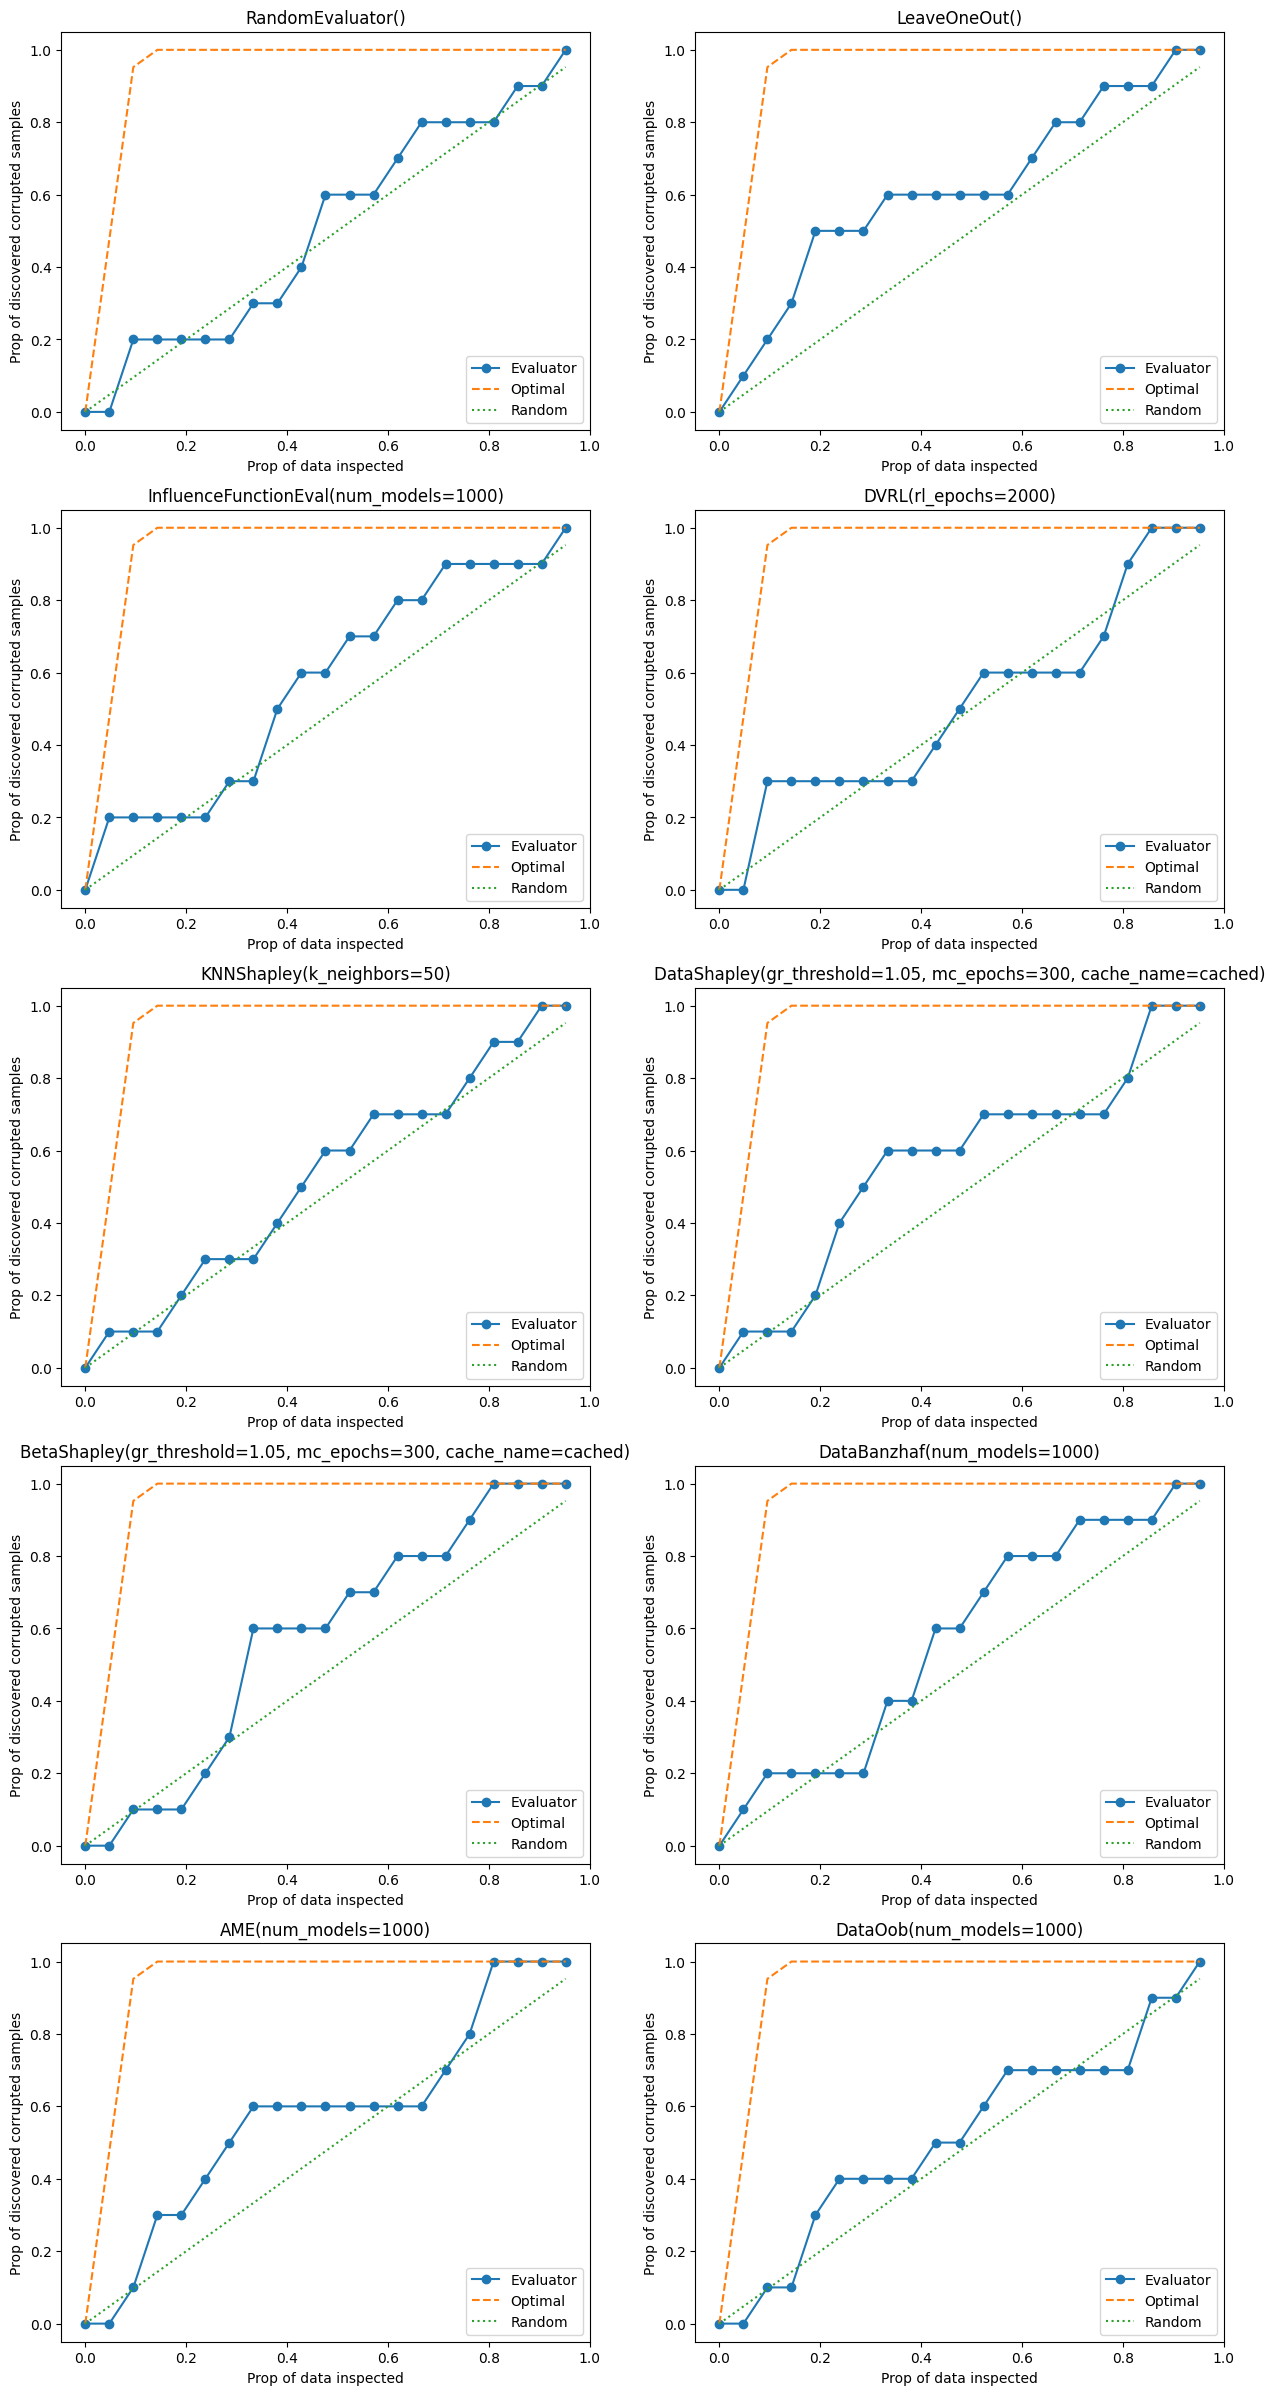

In [9]:
fig = plt.figure(figsize=(15, 30))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

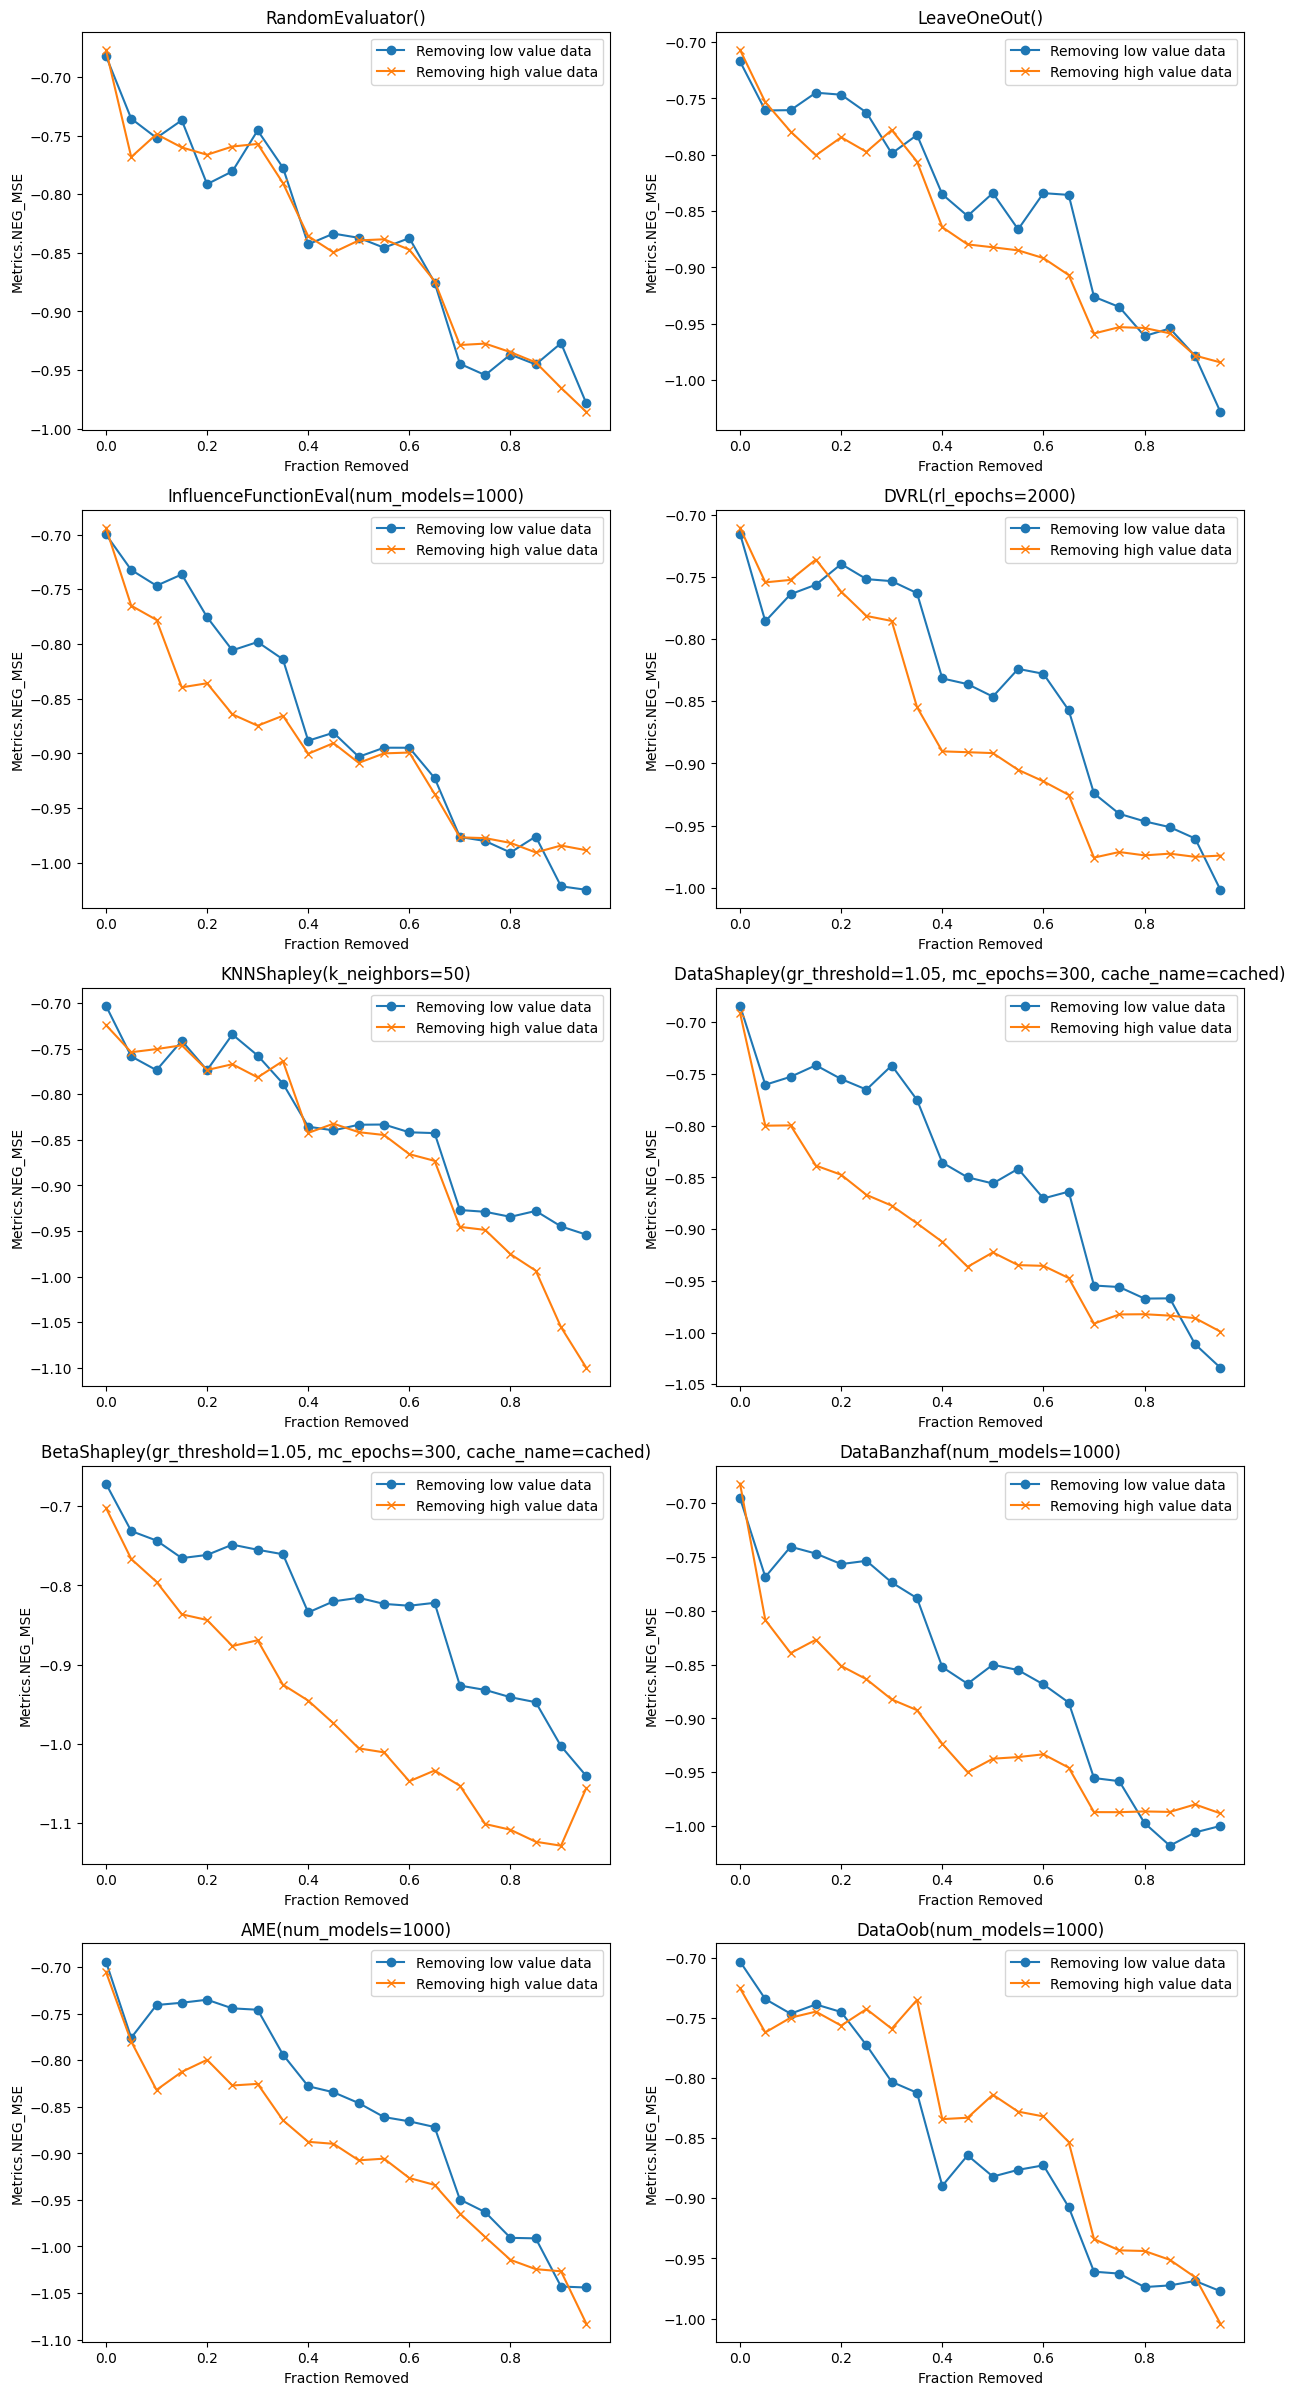

In [10]:
fig = plt.figure(figsize=(15, 30))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [11]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.NEG_MSE,remove_most_influential_first_Metrics.NEG_MSE,axis
RandomEvaluator(),-0.681727,-0.676593,0.0
RandomEvaluator(),-0.735372,-0.768161,0.05
RandomEvaluator(),-0.751806,-0.748653,0.1
RandomEvaluator(),-0.736726,-0.759959,0.15
RandomEvaluator(),-0.791313,-0.766198,0.2
...,...,...,...
DataOob(num_models=1000),-0.962635,-0.943308,0.75
DataOob(num_models=1000),-0.973838,-0.94384,0.8
DataOob(num_models=1000),-0.972457,-0.951171,0.85
DataOob(num_models=1000),-0.968714,-0.965654,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [12]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),40870,0.997819
RandomEvaluator(),10045,0.24363
RandomEvaluator(),43444,0.979834
RandomEvaluator(),21270,0.176125
RandomEvaluator(),9241,0.597138
...,...,...
DataOob(num_models=1000),12321,-0.907977
DataOob(num_models=1000),29988,-0.545513
DataOob(num_models=1000),55485,-0.043119
DataOob(num_models=1000),27319,-1.749442
